In [1]:
import re
from collections import Counter

In [6]:
import pandas as pd
import numpy as np
from cytoolz import concat
from wordcloud import WordCloud
import matplotlib.pylab as plt

In [7]:
%precision 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (11,8.2)

pd.set_option('precision', 2)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 125)

Extracting evaluative language from wine tasting notes
Load Data: do some basic sanity checks

In [11]:
df = pd.read_csv('http://goo.gl/93fJ32', compression='gzip')
df

,review_points,review_text,review_time,review_userName,wine_name,wine_variant,wine_year,lang
0,88,"good red rhone with moderate fruit and great structure. this can cellar. Problem I have with Sunstone, in general, they'...",2010-09-28,brigcampbell,2005 Sunstone Vineyard Rapsodie du Soleil,Red Blend,2005,en
1,94,"Layer upon layer of vanilla, floral, berry, wood notes on the nose. Palate was not overwhelming, but very substantial wit...",2006-11-27,Stampy,2003 Branson Coach House Shiraz Rare Single Vineyard Coach House Block,"Shiraz, Syrah",2003,en
2,94,"Ferrieres parade chez moi: Excellent in total; minerals, trop fruit w/almonds; beaut. nose; lots of character; great fin...",2002-08-25,peternelson,1998 La Chablisienne Chablis Vieilles Vignes,Chardonnay,1998,en
3,87,"pleasantly surprised with this one. pleasant tasting, simple with good fruit. Great QPR",2009-06-29,ptelgenh,2006 Ramsay Pinot Noir North Coast,Pinot Noir,2006,en
4,88,"Muted note, juicy red fruit on the palate. Medium finish.",2009-10-27,dubdub,2006 Domaine Jean Féry & fils Morey St. Denis,Pinot Noir,2006,en
...,...,...,...,...,...,...,...,...
499995,88,"Darker styled CCR. Earth and acid. Nice, but not particularly memorable for the vintage.",2009-03-22,Armando B,2001 Il Molino di Grace Chianti Classico Riserva,"Sangiovese Blend, Sangiovese",2001,en
499996,91,"Nose: honey, spice, botrytis, some dried fruit, hint of petrol. Palate: honey, spice, some citrus, rather good acidity. F...",2012-05-12,Vintomas,2003 Château de Fargues,Sémillon-Sauvignon Blanc Blend,2003,en
499997,88,"Decanted approx 1hr. Red fruit, casis n hint of vanilla on the nose. Medium body, a bit dry on the palate. It got better ...",2012-08-19,mchiew,2005 Arômes de Pavie,Red Bordeaux Blend,2005,en
499998,86,Agreed that it was quite musty at first but that quickly dissipated. Still somewhat earthy but the fruit is there too. No...,2007-08-20,ToddR911,1998 Beringer Vineyards Cabernet Sauvignon Founders' Estate,Cabernet Sauvignon,1998,en


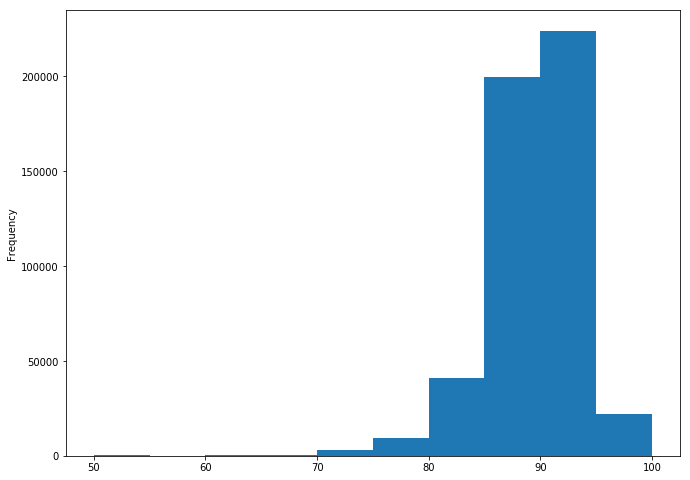

In [12]:
df['review_points'].plot.hist()

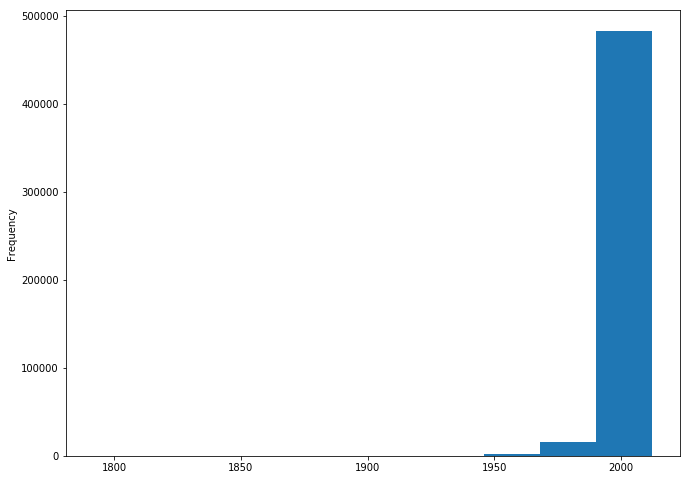

In [13]:
df['wine_year'].plot.hist()

In [14]:
df[df['wine_year']<1825]

,review_points,review_text,review_time,review_userName,wine_name,wine_variant,wine_year,lang
48095,95,Napoleon's Madeira. Good provenance on the bottle and served in the original hand-made 3-part moulded bottle. Pale mahoga...,2005-04-14,IanL,1792 Blandy Madeira Bual,"Bual, Boal",1792,en
366929,100,Celestial-historic and other worldly. the time machine of wines! better than sex,2004-01-27,rarewineman,1792 Blandy Madeira Extra Reserve Solera,White Blend,1792,en
412552,98,"[This Solera has been founded to commemorate the establishment of Blandy's Madeira, and initially contained vintagesdati...",2011-03-24,Anonymous,1811 Blandy Madeira Bual Solera,"Bual, Boal",1811,en
488179,97,"[In his book  Madeira, The Island Vineyard  considered to be the reference in term of Madeira wine books, Noël Cossart...",2011-03-24,Anonymous,1822 Blandy Madeira Verdelho,"Verdelho, Verdejo",1822,en


In [15]:
df['review_time'] = pd.to_datetime(df['review_time'])

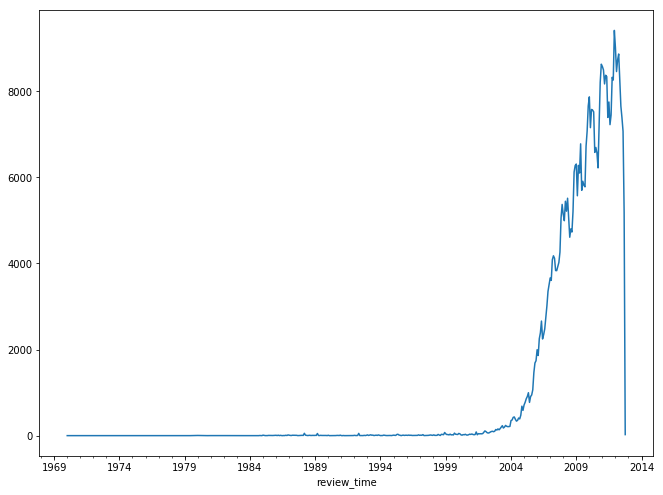

In [20]:
df['review_points'].groupby(df['review_time']\
                           .dt.to_period('M'))\
                           .count().plot()

That's suspicious,, reviews posted to a website in 1970?

In [22]:
df[df['review_time']<'1980']

,review_points,review_text,review_time,review_userName,wine_name,wine_variant,wine_year,lang
18641,88,"keith shared notes from his cellar book. alltogether a better bottle. good fruity aroma, soft and full. more time to sett...",1971-02-08,bacchus,1962 Château Lynch-Bages,Red Bordeaux Blend,1962,en
36156,78,"keith shared notes from his cellar book. good red color, soft at the rim, fruity aroma. still considerable tannin- full f...",1971-01-23,bacchus,1962 Château Lynch-Bages,Red Bordeaux Blend,1962,en
82978,90,great bottle.,1978-01-01,bacchus,1966 Clos Fourtet,Red Bordeaux Blend,1966,en
93469,90,still singing,1978-01-01,bacchus,1967 Château Beychevelle,Red Bordeaux Blend,1967,sv
125306,92,another great bottle.,1976-01-01,bacchus,1967 Château Pavie,Red Bordeaux Blend,1967,en
...,...,...,...,...,...,...,...,...
369964,86,great bottle.,1976-01-01,bacchus,1970 Mirassou Vineyards Zinfandel,Zinfandel,1970,en
415255,90,great bottle.,1979-01-01,bacchus,1967 Château Beychevelle,Red Bordeaux Blend,1967,en
450528,85,"Cherry, chocolate, burnt berries. Very light, good summer red, goes well with meat. Simple. Not pretending to be anything...",1970-01-03,mjmiller1223,2008 Predator Zinfandel Old Vine,Zinfandel,2008,en
480157,94,this was an astounding bottle of wine. unfortunately we did not know enough to keep it until it was fully mature. since i...,1975-01-01,bacchus,1969 Maison Albert Bichot Echezeaux Domaine du Clos Frantin,Pinot Noir,1969,en


In [24]:
df['lang'].value_counts()

en       476803
fr         6263
de         2812
nl         2164
af         1754
          ...  
vi           13
th           10
ru            7
zh-cn         6
zh-tw         2
Name: lang, Length: 36, dtype: int64

In [25]:
df[df['lang']=='th']

,review_points,review_text,review_time,review_userName,wine_name,wine_variant,wine_year,lang
57490,84,เปิดแล้วพร้อมดื่ม ไม่ฝาดมาก กลิ่นหอมดี ยิ่งทิ้งไว้กลิ่นยิ่งหอม,2006-07-17,brutus,2002 Château Croizet-Bages,Red Bordeaux Blend,2002,th
98019,85,กลิ่นหอมพอสมควร ดื่มแล้วมีบอดี้ปานกลาง ใช้ได้,2006-07-04,brutus,2003 Château Plaisance (St. Émilion),Red Bordeaux Blend,2003,th
144448,85,ดื่มแล้วรู้สึกว่าใช้ได้ หวานฝาดได้ลงตัว กลิ่นก็ดี,2006-07-14,brutus,2003 Yalumba Shiraz & Viognier Barossa,"Shiraz Blend, Syrah",2003,th
147358,79,ยังไม่ค่อยมี body เท่าไร,2006-06-20,brutus,2003 Baron Philippe de Rothschild Mouton Cadet,Red Bordeaux Blend,2003,th
178669,89,รสชาติดี กลิ่นใช้ได้,2006-08-23,brutus,2003 Château du Calvaire,Red Bordeaux Blend,2003,th
209877,85,หอมดี body OK,2006-11-01,brutus,2001 Château La Cardonne,Red Bordeaux Blend,2001,th
240182,90,ลองซื้อมาชิม ด้วย 1 ขวด เก็บไว้อีก 1 ขวด รสชาด บอดี้ดีมาก กลิ่นหอม แต่ฝาดไปนิด เพราะ ยังไม่ถึงอายุที่กินได้ แต่ก็นับว่าสุ...,2006-07-23,brutus,2003 Château Giscours,Red Bordeaux Blend,2003,th
319386,92,เป็นอีกตัวที่ชอบและหลงไหลที่เดียว ตัวนี้ดื่มกันหลายคน วันนั้นมี giscour'02 อีกตัวจำไม่ได้ แต่ว่า rauzan segla กินขาด,2006-06-19,brion,2003 Château Rauzan-Ségla,Red Bordeaux Blend,2003,th
371472,79,กลิ่นหอมดี แต่ไม่ค่อยมี Body,2006-06-20,brutus,2003 Château Du Raux,Red Bordeaux Blend,2003,th
493082,90,อร่อยมากๆ ดื่มที่ซูริกประมาณต้นปี ๔๖ แต่ไม่เท่า pontet canet '03,2006-06-19,brion,1998 Château Léoville Poyferré,Red Bordeaux Blend,1998,th


the data looks okay, but filter out the non-EN reviews

In [26]:
df = df[df['lang']=='en']

In [27]:
df['wine_variant'].value_counts()

Pinot Noir                 64629
Red Bordeaux Blend         54855
Cabernet Sauvignon         53154
Chardonnay                 34802
Syrah                      22361
                           ...  
Stanushina                     1
Beli Pinot, Pinot Blanc        1
Ryzlink vlassky                1
Tavkveri, St. Vincent          1
Karalahna                      1
Name: wine_variant, Length: 640, dtype: int64

Calculate the avg score separately for each variant. Using Groupby:

In [28]:
df.groupby('wine_variant')['review_points'].mean()

wine_variant
Abouriou                        87.67
Acolon                          81.50
Adakarasi                       78.00
Agiorgitiko                     86.54
Aglianico                       88.64
                                ...  
Zweigelt/Blaufrankisch Blend    87.50
Çalkarası                       82.00
Öküzgözü                        80.50
Šipon, Furmint                  85.00
Žlahtina                        86.00
Name: review_points, Length: 640, dtype: float64

Sort in descending order.

In [29]:
df.groupby('wine_variant')['review_points'].mean().sort_values(ascending=False)

wine_variant
Strawberry             96.00
Rosenmuskateller       94.00
Noiret                 94.00
Tokay, Muscadelle      93.88
Boal                   93.36
                       ...  
Phoenix                74.00
Steuben                74.00
Trollinger, Schiava    73.00
Albillo                70.00
Delaware               66.00
Name: review_points, Length: 640, dtype: float64

'Strawberry' is the best kind of wine? or too short reviews? Filter only the variants with reasonably large number of reviews.

In [30]:
variety = df.groupby('wine_variant')['review_points'].agg(['mean','count'])

In [31]:
variety

,mean,count
wine_variant,,
Abouriou,87.67,3
Acolon,81.50,2
Adakarasi,78.00,1
Agiorgitiko,86.54,131
Aglianico,88.64,950
...,...,...
Zweigelt/Blaufrankisch Blend,87.50,24
Çalkarası,82.00,4
Öküzgözü,80.50,4


In [32]:
variety[variety['count']>1000]['mean'].sort_values(ascending=False)

wine_variant
Champagne Blend                   91.20
Port Blend                        91.01
Nebbiolo                          90.26
Sémillon-Sauvignon Blanc Blend    90.16
Syrah                             89.74
                                  ...  
Malbec                            87.12
Gamay                             87.08
White Blend                       87.06
Rosé Blend                        86.64
Pinot Grigio, Pinot Gris          85.09
Name: mean, Length: 45, dtype: float64

#### Evaluative Languages
What kind of language do reviews use
- when it comes to bad wine
- or good wine

In [33]:
df[df['review_points']<60]

,review_points,review_text,review_time,review_userName,wine_name,wine_variant,wine_year,lang
1945,50,Undrinkable. Not sure if it was corked or just a poor wine.,2010-10-25,JCGuthrie,2002 Azienda Agricola Moroder Rosso Conero,Montepulciano,2002,en
3473,50,"Great aroma. Howeve, the taste was flat. Past it's prime.",2009-11-29,EDQ,1998 Raymond Vineyard & Cellar Cabernet Sauvignon,Cabernet Sauvignon,1998,en
3863,54,You might be wondering how a wine scores 54 points. Add to the 50 Pts the wine earns for being wet and give it; 1 Pt for ...,2011-12-05,Jeff Leve,1921 Château Pajot,Sémillon-Sauvignon Blanc Blend,1921,en
9829,50,Tastless! Someone brought this to a dinner party and bragged that they had 2 more bottles. Very weak.,2010-03-01,dhammer53,2005 Château Labourdette,Red Bordeaux Blend,2005,en
12475,58,"For F**k's Sake, who swapped the Robitussin cough syrup for this bottle of wine?",2009-07-18,VinLancaster,2008 Pampa de Baco Malbec,Malbec,2008,en
...,...,...,...,...,...,...,...,...
485149,50,After sitting two weeks I drank a second bottle and my opinion is now...this is crap. I am trying to return my other 4 bo...,2007-06-22,guitarguy,2004 Grant Burge Sauvignon Blanc Kraft,Sauvignon Blanc,2004,en
488220,50,Wine was old and spoiled -- it had been hiding in the back of my cellar and didn't survive...,2009-08-02,Astromac06,1998 Robert Mondavi Winery Cabernet Sauvignon Coastal,Cabernet Sauvignon,1998,en
498315,50,The most offensive wine I've drank in recent memory. Heavy overtones of gasoline and chemicals made this a quick throwaway.,2011-10-07,charsobees,2006 Brooklyn Oenology Social Club Red,"Merlot Blend, Merlot",2006,en
499218,50,This was one of the worst wines I have ever tasted...short and muted...terrible fruit and flavor. Very poorly put togethe...,2010-09-27,PA Cross,2009 Luli Chardonnay,Chardonnay,2009,en


In [34]:
df[df['review_points'] == 100]

,review_points,review_text,review_time,review_userName,wine_name,wine_variant,wine_year,lang
2312,100,Whoa Boy! Where have all the good wines gone? This is surely one of them! This perfect Bordeaux has everything I would ev...,2011-11-04,CMCARNES,1982 Château Mouton Rothschild,Red Bordeaux Blend,1982,en
2671,100,"Hands down, this was EASILY the wine of the night. OMFG, this is absolutely perfect with off the charts complexity. The p...",2005-02-11,Eric,1990 Château Margaux,Red Bordeaux Blend,1990,en
2960,100,"Smooth, well-balanced, a little spice, maybe some bacon. Stood up to carbs and full meal, appetizers through dessert.",2010-11-25,karenlynnvincent,2007 Hartford Court Pinot Noir Velvet Sisters,Pinot Noir,2007,en
4510,100,"Absolutely perfect, and one more at home for later.",2012-03-25,csjaap,1998 Cain Vineyard & Winery Cain Five,Red Bordeaux Blend,1998,en
5753,100,Lived up to every bit of the hype. My fiancee tried to lick the inside of the bottle clean.,2008-01-16,DRLSUBARU,2002 Château d'Yquem,Sémillon-Sauvignon Blanc Blend,2002,en
...,...,...,...,...,...,...,...,...
493671,100,"The well-known Christie's label, ""Boal 1827"" written in paint underneath. Very intense but not very deep amber colour, bu...",1999-06-26,Xavier Auerbach,1827 Quinta do Serrado Madeira Boal,Boal,1827,en
496439,100,Drank w Carmine at coast.,2010-06-19,MySacha,1997 Salon Champagne Brut Blanc de Blancs,Chardonnay,1997,en
496968,100,probably the best chateauneuf i've had- still young; purple- a little lightening at the rim; the fragrance was remarkable...,2011-02-13,jonnyoro,1990 Clos du Mont-Olivet Châteauneuf-du-Pape La Cuvée du Papet,Red Rhone Blend,1990,en
497312,100,Decanted three times over five hours. Opaque and thick looking. Almost black with a deep garnet rim. The superlative nose...,2010-07-24,Matt Scott,1982 Château Léoville Las Cases,Red Bordeaux Blend,1982,en


### 1st step in text processing: normalization & tokenization.
- normalization: making everything lowercase (str.lower()) & replacing non-letters w/ spaces (re.sub(r'[^a-z-]', ' ', ...))
- tokenization: To get tokens, we'll divide up the string by spaces (str.split()) & add the result as a new column in the 'tokens' dataframe.

In [36]:
print(df.loc[0]['review_text'])

good red rhone with moderate fruit and great structure. this can cellar.  Problem I have with Sunstone, in general, they're are a horrible QPR. OK wine but charging way too much.


In [37]:
def tokenize(text):
    return re.sub(r'[^a-z-]', ' ', text.lower()).split()

In [40]:
print(tokenize(df.loc[0]['review_text']))

['good', 'red', 'rhone', 'with', 'moderate', 'fruit', 'and', 'great', 'structure', 'this', 'can', 'cellar', 'problem', 'i', 'have', 'with', 'sunstone', 'in', 'general', 'they', 're', 'are', 'a', 'horrible', 'qpr', 'ok', 'wine', 'but', 'charging', 'way', 'too', 'much']


In [41]:
df['tokens'] = df['review_text'].apply(tokenize)

C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


To find <b>Evaluative Language</B>, we use <b><i>pointwise mutual information</b></i> to find words that occur in a subset of review texts w/ greater than chance frequency: 

PMI(w, subset) = log2(f(w, subset) * N)/f(w)*N(subset)

To calculate this, we need the frequency of a word in a subset <b><i>f(w, subset)</i></b>, the overall frequency of a word <b><i>f(w)</i></b>, the number of words in a subset <b><i>N(subset)</i></b>, and the total number of words <i><b>N<,/b></i>.

First, count words overall and in the bad reviews:

In [42]:
freq = pd.DataFrame({'all':Counter(concat(df['tokens'])),
                    'bad':Counter(concat(df[df['review_points']<70]['tokens']))})
freq.sort_values('all')

,all,bad
lingerer,1,NaN
mothful,1,NaN
mothfilling,1,NaN
motherfucking,1,NaN
motherf,1,NaN
...,...,...
with,388937,439.0
of,456242,843.0
a,632894,1281.0
the,731181,1660.0


Calculate PMI:

In [43]:
freq['bad_mi'] = np.log2((freq['bad']*np.sum(freq['all']))/freq['all']*np.sum(freq['bad']))

Sort:

In [44]:
freq.sort_values('bad_mi', ascending = False)

,all,bad,bad_mi
flagellation,1,1.0,39.54
sugar-tasting,1,1.0,39.54
blue-straw-green,1,1.0,39.54
loco,1,1.0,39.54
ewp,1,1.0,39.54
...,...,...,...
zynthesis,1,NaN,NaN
zz,1,NaN,NaN
zzing,1,NaN,NaN
zzreafy,1,NaN,NaN


Problem: getting extreme PMI values for very rare words (like the problem in the avg scores for variants)

Solution: filter out all the words w/ a frequency below a certain threshold:

In [45]:
freq[freq['bad'] > 10].sort_values('bad_mi', ascending = False)

,all,bad,bad_mi
disgusting,47,11.0,37.45
yuck,112,23.0,37.26
avoid,449,90.0,37.22
swill,75,15.0,37.22
drain,359,67.0,37.12
...,...,...,...
cherries,26268,11.0,28.32
fruits,36944,14.0,28.18
nice,122774,40.0,27.96
spice,43312,14.0,27.95


Put the whole thing into a word cloud.

In [46]:
v = dict(freq[freq['bad'] > 10].sort_values('bad_mi', ascending = False)['bad_mi'][:100])
i = WordCloud(width=1000, height = 1000).generate_from_frequencies(v).to_image()

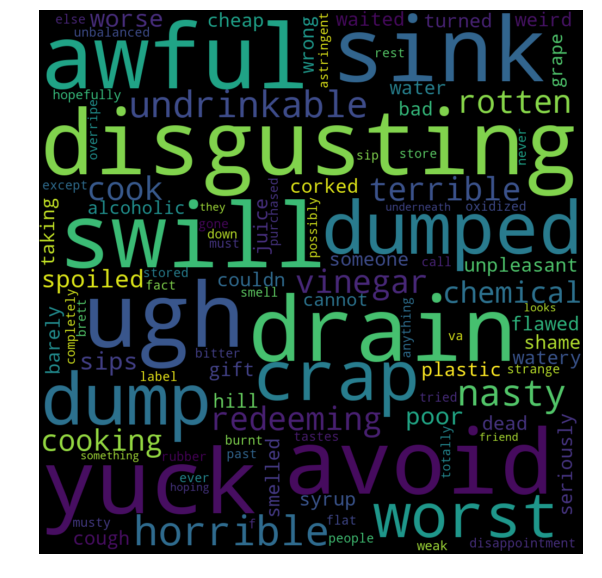

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(i, interpolation = 'bilinear')
plt.axis('off')
plt.show()

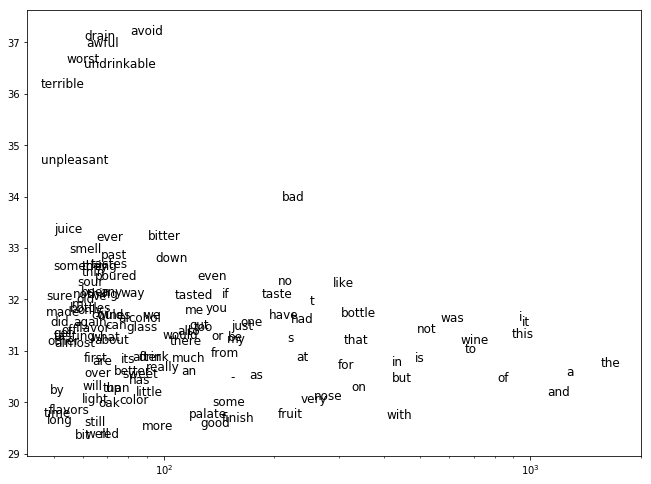

In [51]:
words = freq[freq['bad'] > 50]
plt.xscale('log')
plt.scatter(words['bad'], words['bad_mi'], alpha = 0)
for (x, y, t) in zip(words['bad'], words['bad_mi'], words.index):
    plt.text(x, y, t, horizontalalignment = 'center', verticalalignment ='center', fontsize = 'large')
plt.show()

In [52]:
words

,all,bad,bad_mi
-,81643,154.0,30.49
a,632894,1281.0,30.59
about,23285,72.0,31.20
after,36397,90.0,30.88
again,15913,63.0,31.56
...,...,...,...
wines,16792,73.0,31.70
with,388937,439.0,29.75
worst,440,60.0,36.67
would,33518,111.0,31.30


Do the same for good reviews:

In [59]:
freq['good'] = pd.Series(Counter(concat(df[df['review_points'] > 95]['tokens'])))
freq['good_mi'] = np.log2((freq['good']*np.sum(freq['all']))/(freq['all']*np.sum(freq['good'])))

In [60]:
freq[freq['good'] > 10].sort_values('good_mi', ascending=False)

,all,bad,bad_mi,good,good_mi
speechless,38,NaN,NaN,30.0,4.63
cranny,30,NaN,NaN,23.0,4.59
nook,34,NaN,NaN,22.0,4.35
omfg,27,NaN,NaN,17.0,4.31
atlantis,22,NaN,NaN,12.0,4.10
...,...,...,...,...,...
thin,8205,64.0,32.54,29.0,-3.17
value,14418,12.0,29.31,37.0,-3.63
simple,10082,22.0,30.70,23.0,-3.80
qpr,12491,4.0,27.93,18.0,-4.46


In [61]:
v2 = dict(freq[freq['good'] > 10].sort_values('good_mi', ascending = False)['good_mi'][:100])
i2 = WordCloud(width = 1000, height = 1000).generate_from_frequencies(v2).to_image()

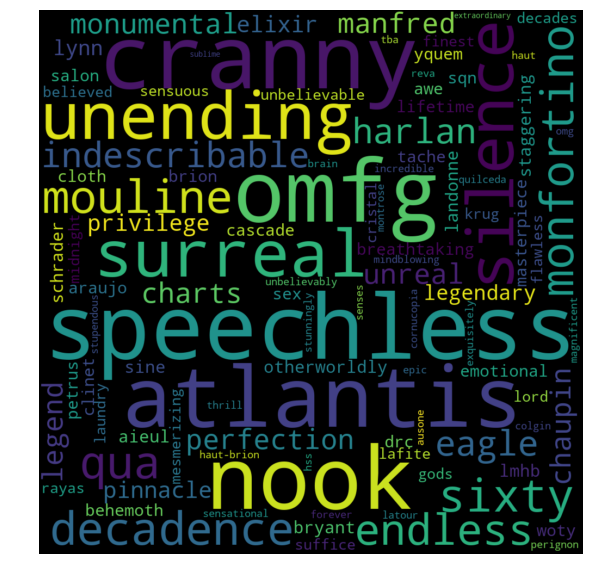

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(i2,interpolation='bilinear')
plt.axis('off')
plt.show()

further examination:

In [67]:
def match(pattern):
    for i, r in df[df['review_text'].str.contains(pattern, case=False)].iterrows():
        text = re.sub(r'('+pattern+r')', r'<\1>', r['review_text'], flags=re.I)
        print(text)
        print('---')

In [68]:
match('cranny')

Popped and poured. Mouth coating cassis, cherry, & cocoa. Velvety sense of weight covering every nook & <cranny> of the palate. Not so much evolution in the decanter but really turned up to eleven with steaks. Too uncomplicated to be 100 pts, but it does what it does very well. Wine of the night for 3 of 4 diners, with the 2003 Quilceda Creek taking a not too shabby 2nd place.
---
Pitch black color with notes of deep, black, ripe fruit, pepper, spearmint and herbs. Huge wine. Very extracted, rich and complex. The mouthfeel takes over every nook and <cranny> of your tasting senses. Amazing stuff.  Very young, will age for decades.
---
I believe this is the last vintage of Babcock's Nook & <Cranny> as phylloxera resulted in removal of these vines from his estate. I probably should have laid this down longer but on a perfect day and marinated skirt steak on the grill it called my name. Rich aromas of ripe blackberry, blueberry and boysenberry syrup lead to a similar experience on the pala

In [69]:
match('atlantis')

This bottle was damned near close to perfection and in my Top Three SQN grenaches holding company with the Inaugural and the Ode To E. Amazing juice! Started off with a huge, classic grenache nose but a bit thin in the mid palate and on the finish. After about an hour, the fruit lushed out and gained substantial weight. Not as big as the <Atlantis> but more refined and almost feminine by SQN standards. I would advise a 1-2 hour decant at this stage. Simply stunning.
---
91;89. Beautiful; dark center, brilliant color, very dense all the way to the rim. Thick. This wine is starting to shut down. Tried one in Sweden 2 weeks ago and the bottle last night confirmed it. After 2 hours decanting it was still very closed. Nice nose, heady, rich and ripe. Initial mouthfeel was round and fat but then the acid took over and the wine became almost austere. With the wine not quite opened up, the acid is perceived as huge and the wine felt almost sour. We opened up a bottle of something else and dran

In [70]:
match('aieul')

Good but not a profound <Aieul>. Still, Grandpappy's Blend never fails to satisfy.
---
Decanted and drank right away. This wine is a consistently strong with well balanced red fruits and good finish. We opened this bottle after finishing the 2003 Mon <Aieul> and, while it is a very good wine at its price point, it was obviously over matched. A great night of wine and dinner.
---
Interesting.. i would NEVER put this as an Italian wine. no old world feel what so ever. :) on the other hand. hedonistic. candied fruit, bubble gum.. some people who never drink this, but the crowd seemed to like it. i was ok for the first few sips but after a while, i went back to the cuvee mon <aieul>..  ok. nothing wrong.. not sure it's that 'great'.
---
Slow Od for 8 hrs. Ive been in love with this wine since day one, and this bottle did little to dissuade my love affair with the 01 Mon <Aieul>. When you take you first sip, your tongue is just slathered with the best possible CdP kaleidoscope of kirsch l

In [ ]:
.

In [2]:
source activate ling583

SyntaxError: invalid syntax (<ipython-input-2-02014dd119e9>, line 1)

In [ ]:
df = pd.read_msgpack('articles.msg')
len(df)
import spacy
nlp = spacy.load('en', disable = ['parser']) #pull out proper names, but we don't care subject/object > disable parser
from spacy import displacy
doc =

displacy.render(doc, style = 'ent', jupyter = True)

print([e.lower_ for e in doc.ents if e.label_ = 'PERSON'])

df = df.sample(5000)

df['doc'] = list(nlp.pipe(df['text']))

def get_top_persons(docs, k = 5):
    freq = Counter(filter(None, (e.orth_.strip() #removes the blank spaces which is not names in English
                                for d in docs
                                for e in d.ents if e.label_ == 'PERSON')))
    return freq.most_common(k)

df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.to_period('W') #pull the week for individual date
df.groupby('week')['doc'].count()
persons = df.groupby('week')['doc'].apply(get_top_persons)
pd.set_option('max_colwidth', 100)
persons
